**ISSA Salim** <br>
24 Décembre 2024 <br>
## Reconnaissance faciale par réseaux de neurones convolutifs

### Importation des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Input,Flatten,Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.datasets import fetch_olivetti_faces
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-28 19:56:36.987265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Récupération du jeu de données (Olivetti Research Laboratory face database)

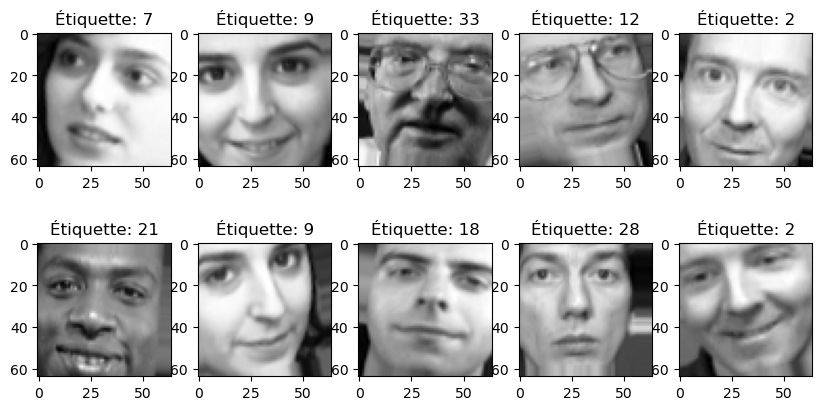

In [2]:
# Chargement des données
donnees = fetch_olivetti_faces(shuffle=False,random_state=42)

# Récupération des images et de leurs étiquettes
images = donnees.images
etiquettes = donnees.target # elles nous indiquent de quel individu est l'image

images = images[..., np.newaxis]  # (400, 64, 64, 1) pour l'augmentation des données

# Augmentation des données pour avoir assez d'échantillons

# Définir les augmentations possibles
generateur_images = ImageDataGenerator(
    rotation_range=15, # Rotation aléatoire jusqu'à 15 degrés
    width_shift_range=0.1, # Décalage horizontal aléatoire jusqu'à 10 % de la largeur de l'image
    height_shift_range=0.1, # Décalage vertical aléatoire jusqu'à 10 % de la hauteur de l'image
    zoom_range=0.1, # Zoom aléatoire jusqu'à 10 % de l'échelle originale
    horizontal_flip=True, # Inversion horizontale aléatoire
    fill_mode='nearest'  # Remplir les pixels vides après transformation
)

images_augmentees = []
etiquettes_augmentees = []

# Nombre total d'images souhaité
taille_objectif = 4000

# Nombre d'exemples généré par image originale
augmentations_par_image = taille_objectif // len(images)

# Génération des augmentations pour chaque image
for i, image in enumerate(images):
    etiquette = etiquettes[i]  # étiquette correspondante

    # Création d'un lot d'une seule image pour le générateur
    lot_image = np.expand_dims(image, axis=0)  # (1, 64, 64, 1)
    
    for _ in range(augmentations_par_image):
        for image_augmentee in generateur_images.flow(lot_image, batch_size=1):
            # Ajouter l'image augmentée et son label
            images_augmentees.append(image_augmentee[0])
            etiquettes_augmentees.append(etiquette)
            break  # Une seule image par itération pour éviter une boucle infinie

images_augmentees = np.array(images_augmentees)
etiquettes_augmentees = np.array(etiquettes_augmentees)

images = images_augmentees
etiquettes = etiquettes_augmentees

nombre_individus = len(set(etiquettes))
nombre_images = images.shape[0]
nombre_pixels = images.shape[1]

# Affichages de 10 images choisies au hasard
n_lignes,n_colonnes = 2,5  # nombres de lignes et de colonnes
figure,axes = plt.subplots(n_lignes,n_colonnes,figsize=(10,5))
for i in range(n_lignes):
    for j in range(n_colonnes):
        k = random.randint(0,images.shape[0]-1)
        axes[i,j].imshow(images[k],cmap='gray')
        axes[i,j].set_title(f"Étiquette: {etiquettes[k]}")
        k += 1
    
plt.show()

### Préparation du jeu de données (séparation)

In [3]:
#pourcentage_entrainement = 80 # taux à considérer pour l'entraînement
pourcentage_validation = 20 # taux à considérer pour la validation
pourcentage_prediction = 20 # taux à considérer pour la prédiction
X,y = shuffle(images,etiquettes) # mélange des données
X_entrainement,X_validation,y_entrainement,y_validation = train_test_split(X,y,test_size=pourcentage_validation/100,random_state=42)
X_validation,X_prediction,y_validation,y_prediction = train_test_split(X_validation,y_validation,test_size=pourcentage_prediction/100,random_state=42)

print('Entraînement: {0:2d} images.'.format(len(y_entrainement)))
print('Validation: {0:2d} images.'.format(len(y_validation)))
taille_ensemble_prediction = len(y_prediction)
print('Prédiction: {0:2d} images.'.format(taille_ensemble_prediction))

Entraînement: 3200 images.
Validation: 640 images.
Prédiction: 160 images.


### Formatage des données pour l'entraînement

In [4]:
#X_entrainement /= 255
#X_validation /= 255
#X_prediction /= 255

# Redimensionnement pour l'utilisation du réseau de neurones convolutif
X_entrainement = X_entrainement.reshape(len(y_entrainement),nombre_pixels,nombre_pixels,1)
X_validation = X_validation.reshape(len(y_validation),nombre_pixels,nombre_pixels,1)
X_prediction = X_prediction.reshape(len(y_prediction),nombre_pixels,nombre_pixels,1)

### Création du modèle de réseau de neurones

In [5]:
reseau_convolutif = tf.keras.Sequential()
# 3 couches de convolution, avec un nombre de filtres augmentant progressivement: 32, 64 puis 128
reseau_convolutif.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(64,64,1),activation='relu'))
reseau_convolutif.add(MaxPooling2D(pool_size=(2, 2)))
reseau_convolutif.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(64,64,1),activation='relu'))
reseau_convolutif.add(MaxPooling2D(pool_size=(2, 2)))
reseau_convolutif.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=(64,64,1),activation='relu'))
reseau_convolutif.add(MaxPooling2D(pool_size=(2, 2)))
# remise à plat
reseau_convolutif.add(Flatten())
# Couche dense classique ANN
reseau_convolutif.add(Dense(256,activation='relu'))
# Couche de sortie (étiquettes de 0 à 39)
reseau_convolutif.add(Dense(40, activation='softmax'))

2024-12-28 19:56:42.172403: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Compilation du modèle

In [6]:
early_stop = EarlyStopping(monitor='val_loss',patience=2) # pour arrêter le modèle en cas d'overfitting (régularisation par arrêt anticipé)

reseau_convolutif.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
reseau_convolutif.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

### Entraînement (apprentissage)

In [7]:
reseau_convolutif.fit(x=X_entrainement, 
            y=y_entrainement, 
            validation_data=(X_validation,y_validation), 
            epochs=25,
            callbacks=[early_stop])

Epoch 1/25
100/100 [==============================] - 15s 140ms/step - loss: 3.6819 - accuracy: 0.0319 - val_loss: 3.6179 - val_accuracy: 0.0750
Epoch 2/25
100/100 [==============================] - 18s 178ms/step - loss: 2.4386 - accuracy: 0.3253 - val_loss: 1.7745 - val_accuracy: 0.4469
Epoch 3/25
100/100 [==============================] - 17s 165ms/step - loss: 1.1486 - accuracy: 0.6422 - val_loss: 0.9339 - val_accuracy: 0.7125
Epoch 4/25
100/100 [==============================] - 19s 189ms/step - loss: 0.5158 - accuracy: 0.8375 - val_loss: 0.5747 - val_accuracy: 0.8266
Epoch 5/25
100/100 [==============================] - 19s 191ms/step - loss: 0.3202 - accuracy: 0.9025 - val_loss: 0.4764 - val_accuracy: 0.8469
Epoch 6/25
100/100 [==============================] - 20s 198ms/step - loss: 0.1604 - accuracy: 0.9522 - val_loss: 0.4217 - val_accuracy: 0.8734
Epoch 7/25
100/100 [==============================] - 21s 211ms/step - loss: 0.1250 - accuracy: 0.9603 - val_loss: 0.3535 - val_ac

### Évaluation du modèle

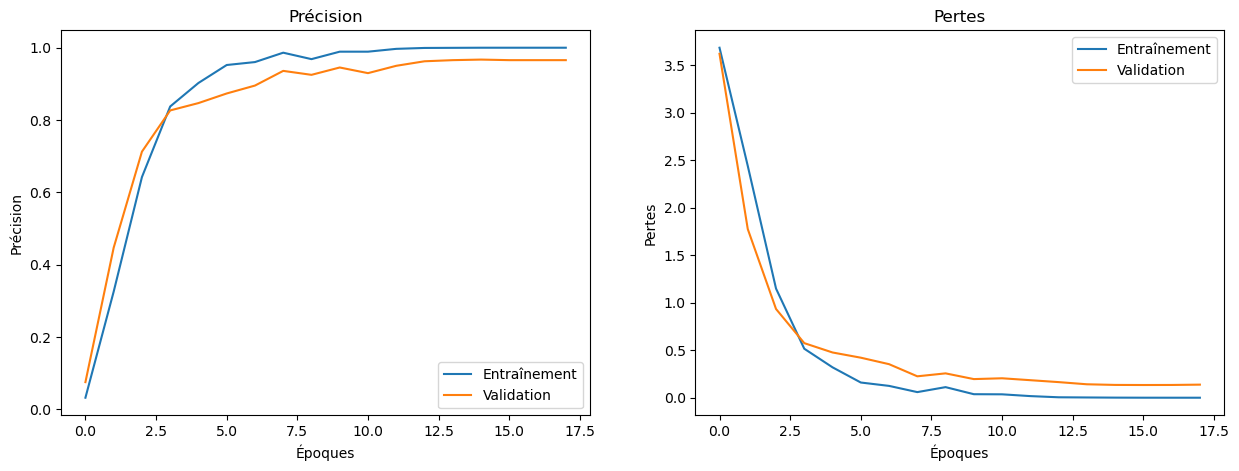

In [8]:
pertes = pd.DataFrame(reseau_convolutif.history.history)

figure,axes = plt.subplots(1,2,figsize=(15, 5))
# Précision
axes[0].plot(pertes['accuracy'],label='Entraînement')
axes[0].plot(pertes['val_accuracy'],label='Validation')
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Précision')
axes[0].set_title('Précision')
axes[0].legend()

# Pertes
axes[1].plot(pertes['loss'],label='Entraînement')
axes[1].plot(pertes['val_loss'],label='Validation')
axes[1].set_xlabel('Époques')
axes[1].set_ylabel('Pertes')
axes[1].set_title('Pertes')
axes[1].legend()

plt.show()

### Prédiction sur une image choisie au hasard

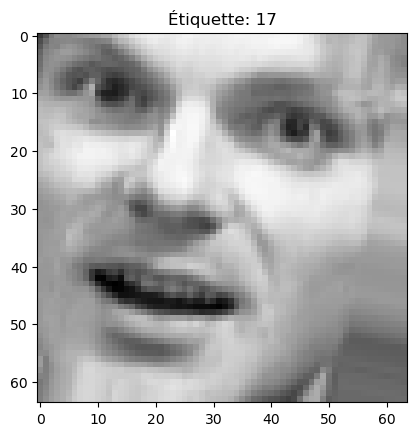

Étiquette prédite: 17


In [9]:
choix = random.randint(0,taille_ensemble_prediction-1)
image_choisie = X_prediction[choix]
etiquette_choisie = y_prediction[choix] # récupération de la classe de l'image (individu auquel elle appartient)
#print("Étiquette de l'individu tiré: {0:2d}".format(etiquette_choisie))

# Affichage de l'individu
plt.imshow(image_choisie,cmap='gray')
plt.title("Étiquette: {0:2d}".format(etiquette_choisie))
plt.show()

# Prédiction
scores_finaux = reseau_convolutif.predict(image_choisie.reshape(1,nombre_pixels,nombre_pixels,1),verbose=0)
etiquette_predite = np.argmax(scores_finaux)
print("Étiquette prédite: {0:2d}".format(etiquette_predite))

### Score global sur l'ensemble de prédiction

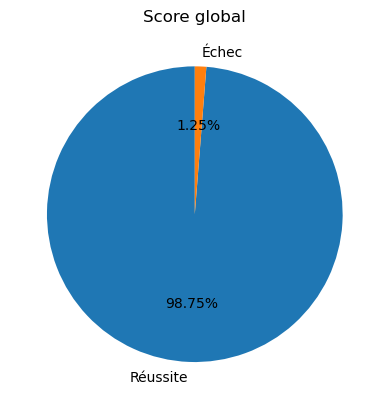

In [10]:
nombre_reussites,nombre_echecs = 0,0
for i in range(taille_ensemble_prediction):
    image = X_prediction[i]
    etiquette = y_prediction[i]
    scores_finaux = reseau_convolutif.predict(image.reshape(1,nombre_pixels,nombre_pixels,1),verbose=0)
    etiquette_predite = np.argmax(scores_finaux)
    if etiquette_predite == etiquette:
        nombre_reussites += 1
    else:
        nombre_echecs += 1
        
pourcentage_reussite = (nombre_reussites/taille_ensemble_prediction)*100
pourcentage_echec = (nombre_echecs/taille_ensemble_prediction)*100

# Diagramme en camembert des résultats obtenus
noms = ['Réussite', 'Échec']
proportions = [pourcentage_reussite,pourcentage_echec]

plt.pie(proportions, labels=noms, autopct='%1.2f%%', startangle=90)
plt.title("Score global")
plt.show()